# Statistical analysis of biological sequences 

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from itertools import product
from scipy.stats import entropy
from statsmodels.tsa.seasonal import seasonal_decompose

Alphabet = ['A','C','T','G']
Blocks = []

maxSize = 5
for k in range(1,maxSize):
    Blocks.append([''.join(i) for i in product(Alphabet, repeat = k)])
    
def MakeRollingPlot(dataframe,ax,function,rolling=30,headers=Blocks[0],label=True):
    colors = [plt.cm.bone(val) for val in np.linspace(0,0.75,num=len(headers))]
    for k,val in enumerate(headers):
        plot_data = dataframe[val].apply(function).rolling(rolling).mean()
        plot_data = (plot_data-plot_data.min())/(plot_data.max()-plot_data.min())
        plot_data.plot(color=colors[k],ax=ax,label=function.__name__+ '( ['+val+'])')
        if label:    
            ax.legend(loc=4)

def MakeRollingPanel(dataframe,functions,rolling=30,headers=Blocks[0]):
    fig,axs =  plt.subplots(len(functions),1,figsize=(17,int(5*len(functions))),sharex=True)
    for k,fun in enumerate(functions):
        MakeRollingPlot(dataframe,axs[k],fun,rolling=rolling,headers=headers)
    fig.suptitle('SARS Cov2 Adaptation Dynamics',fontsize=25)
        
def MakeDoublePanel(dataframe,functions,rolling=30,headers=Blocks[0],label=True):
    fig,axs =  plt.subplots(len(functions),1,figsize=(17,int(5*len(functions))),sharex=True)
    doubledata = dataframe['Pangolin'].nunique().rolling(rolling).mean()
    for k,fun in enumerate(functions):
        MakeRollingPlot(dataframe,axs[k],fun,rolling=rolling,headers=headers,label=label)
        ax2 = axs[k].twinx()
        doubledata.plot(ax=ax2,label='Mean number of variants',color='red')
        ax2.legend(loc=1)
        ax2.set_ylabel('number of unique variants')
        
def MakeDecompositionPlot(Data,axs,columns=Blocks[0],rolling=30,periods=[360,360,360,360]):
    
    ncolumns = len(columns)
    colors = [plt.cm.bone(val) for val in np.linspace(0,0.75,num=ncolumns)]
    
    for k,blk in enumerate(zip(columns,periods)):
        
        val,prd = blk
        
        localdf = Data[val].mean().rolling(rolling).mean()
        localdf = (localdf - localdf.min())/(localdf.max()-localdf.min())
        localdf = localdf.dropna()
    
        decomposition = seasonal_decompose(localdf,period=prd)
        decomposition.trend.plot(ax=axs[0],label=val + ' Trend',color=colors[k])
        decomposition.seasonal.plot(ax=axs[1],label=val + ' Seasonal',color=colors[k])
        axs[0].legend(loc=4)
        axs[1].legend(loc=4)        
    
def MakeDecompositionPanel(Data,columns=Blocks[0],rolling=30,periods=[360,360,360,360]):
    
    fig,axs = plt.subplots(1,2,figsize=(17,5),sharex=True)
    MakeDecompositionPlot(Data,axs,columns=columns,rolling=rolling,periods=periods)
    fig.suptitle('SARS Cov2 Adaptation Dynamics',fontsize=25)

def MakeDoubleDecompositionPanel(Data,columns=Blocks[0],rolling=30,periods=[360,360,360,360]):
    
    fig,axs = plt.subplots(1,2,figsize=(17,5),sharex=True)
    MakeDecompositionPlot(Data,axs,columns=columns,rolling=rolling,periods=periods)
    doubledata = Data['Pangolin'].nunique().rolling(rolling).mean()
    
    for ax in axs:    
        ax2 = ax.twinx()
        doubledata.plot(ax=ax2,label='Mean number of variants',color='red')
        ax2.legend(loc=1)
        ax2.set_ylabel('number of unique variants')
        
    fig.suptitle('SARS Cov2 Adaptation Dynamics',fontsize=25)
    
def MakeScatterPlot(dataframe,ax,rolling=30,headers=Blocks[0],label=True):
    colors = [plt.cm.bone(val) for val in np.linspace(0,1,num=len(headers)+1)]
    doubledata = dataframe['Pangolin'].nunique().rolling(rolling).mean()
    for k,val in enumerate(headers):
        plot_data = dataframe[val].apply(entropy).rolling(rolling).mean()
        ax.scatter(np.array(doubledata),np.array(plot_data),color=colors[k],label=val,alpha=0.26)
        ax.set_ylabel('Entropy')
        ax.set_xlabel('Mean Number of Variants')
        if label:    
            ax.legend(loc=4)

def MakeScatterPanel(localdata,rolling=30,headers=Blocks[0],label=True):
    
    columns = ['lengthofdayd01','lengthofdayd02','lengthofdayd03','lengthofdayd04',
               'lengthofdayd05','lengthofdayd06','lengthofdayd07','lengthofdayd08',
               'lengthofdayd09','lengthofdayd10']
    
    fig,axs =  plt.subplots(2,5,figsize=(17,10))
    axs = axs.ravel()
    
    for k,head in enumerate(columns):
        innerData = localdata.groupby(head)
        MakeScatterPlot(innerData,axs[k],rolling=rolling,headers=headers,label=label)
        axs[k].set_title(head)


# Loading the data

In [2]:
MetaData = pd.read_csv('/kaggle/input/covid19-metadata/MetaData.csv')
MetaData = MetaData[MetaData['correctdata']==1]
MetaData = MetaData.set_index('id')

KmerData = pd.read_csv('/kaggle/input/covid19-sequences-extended/KmerDataUpd.csv')
KmerData = KmerData.set_index('id')
KmerData = KmerData.loc[MetaData.index]

data = pd.concat([MetaData,KmerData],axis=1)

data['date'] = pd.to_datetime(data['date'])

dataspots = pd.read_csv('/kaggle/input/sunspots/sunspots.csv')
dataspots['date'] = pd.to_datetime(dataspots['date'])
rollingavgspots = dataspots.groupby('date')['dailysunspots'].mean()

data['spots'] = np.array(rollingavgspots.loc[data['date']])
data['normspots'] = data['spots']/data['lengthofday']
data['normspots_sf'] = data['spots']/data['sf_msd']

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Data Visualization 

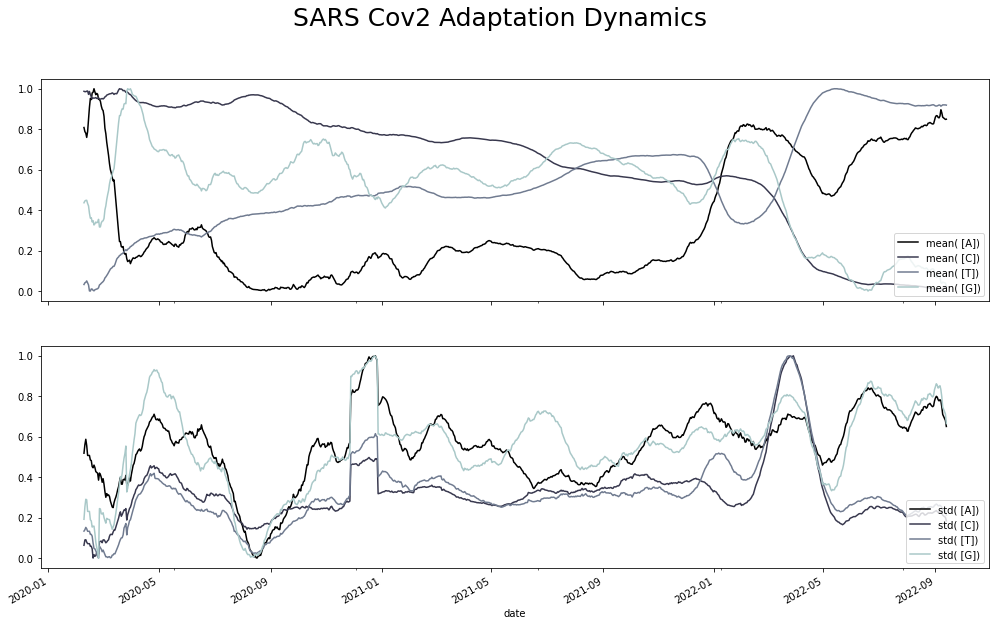

In [3]:
data_date = data.groupby('date')
MakeRollingPanel(data_date, [np.mean,np.std])

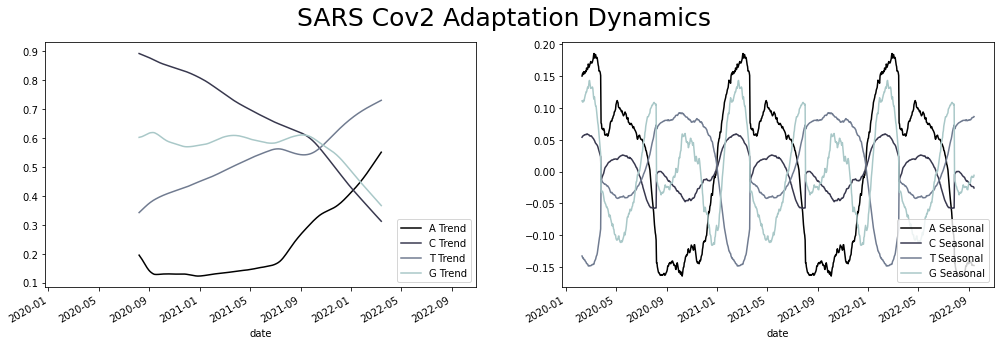

In [4]:
MakeDecompositionPanel(data_date)

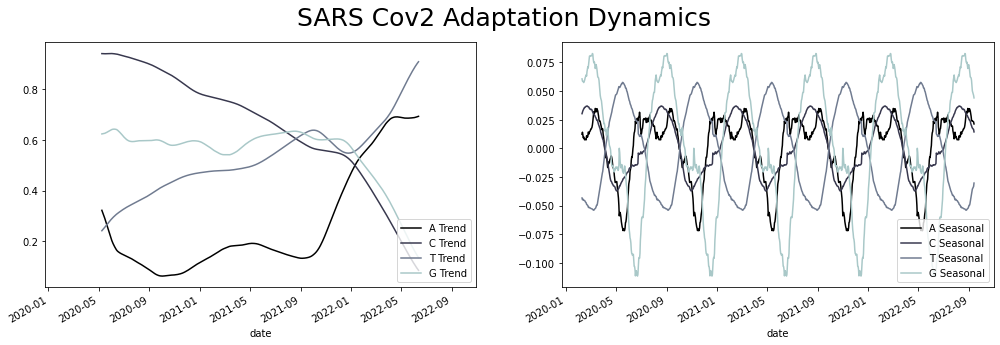

In [5]:
MakeDecompositionPanel(data_date,periods=[180,180,180,180])

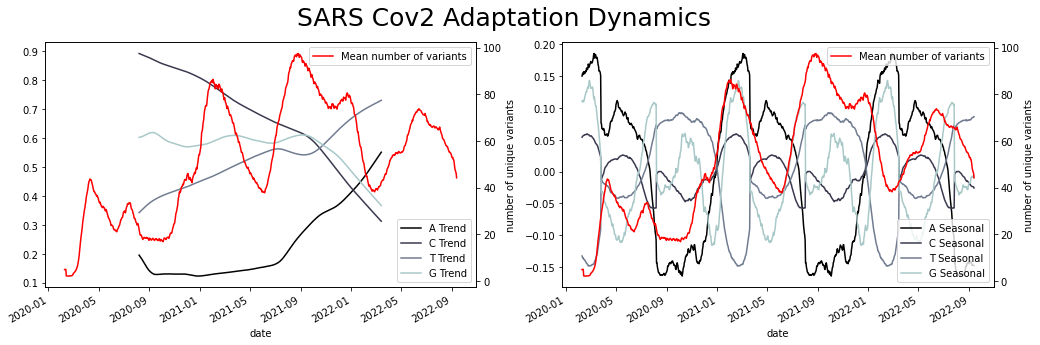

In [6]:
MakeDoubleDecompositionPanel(data_date)

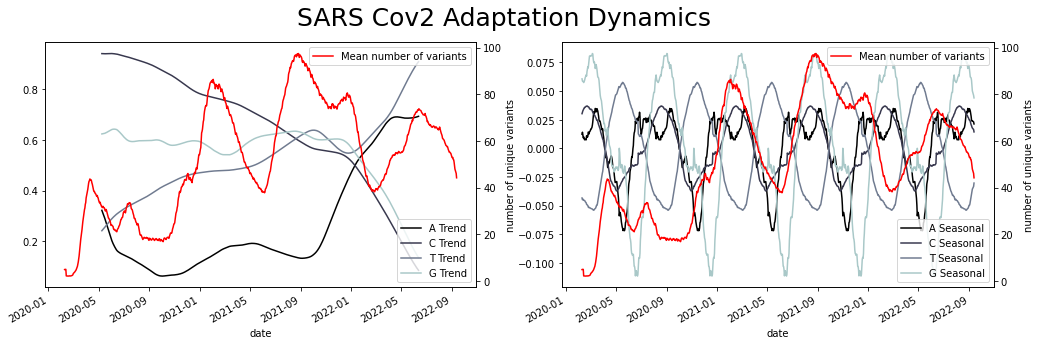

In [7]:
MakeDoubleDecompositionPanel(data_date,periods=[180,180,180,180])

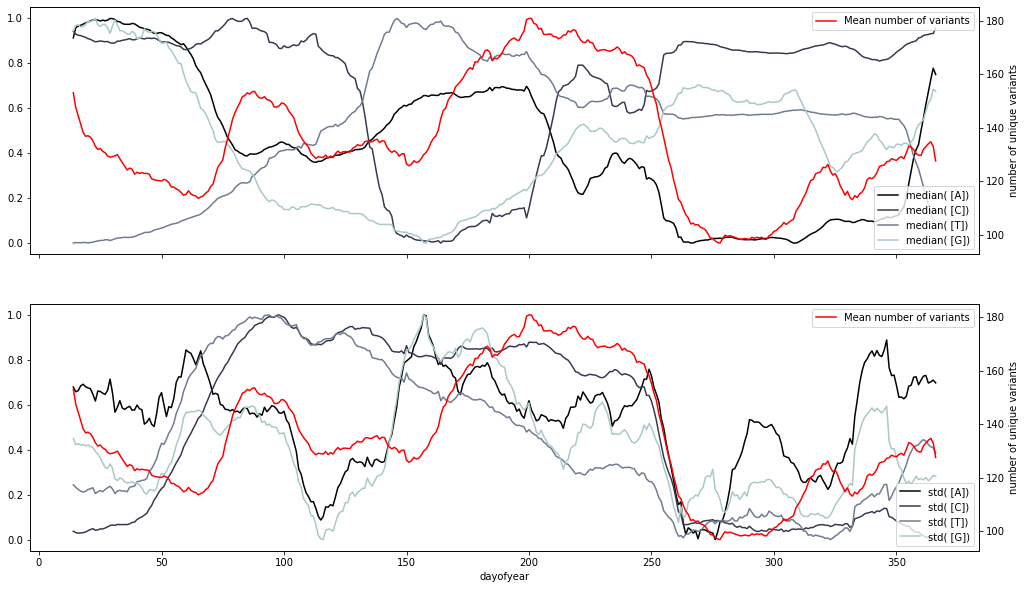

In [8]:
data_doy = data.groupby('dayofyear')
MakeDoublePanel(data_doy, [np.median,np.std],rolling=14)

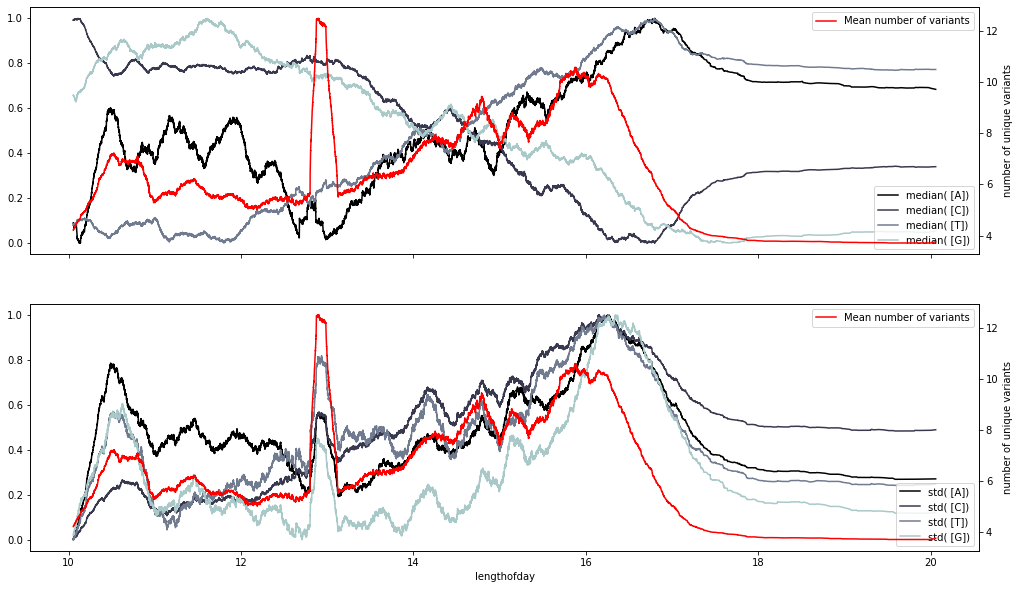

In [9]:
data_ld = data.groupby('lengthofday')
MakeDoublePanel(data_ld, [np.median,np.std],rolling=1400)

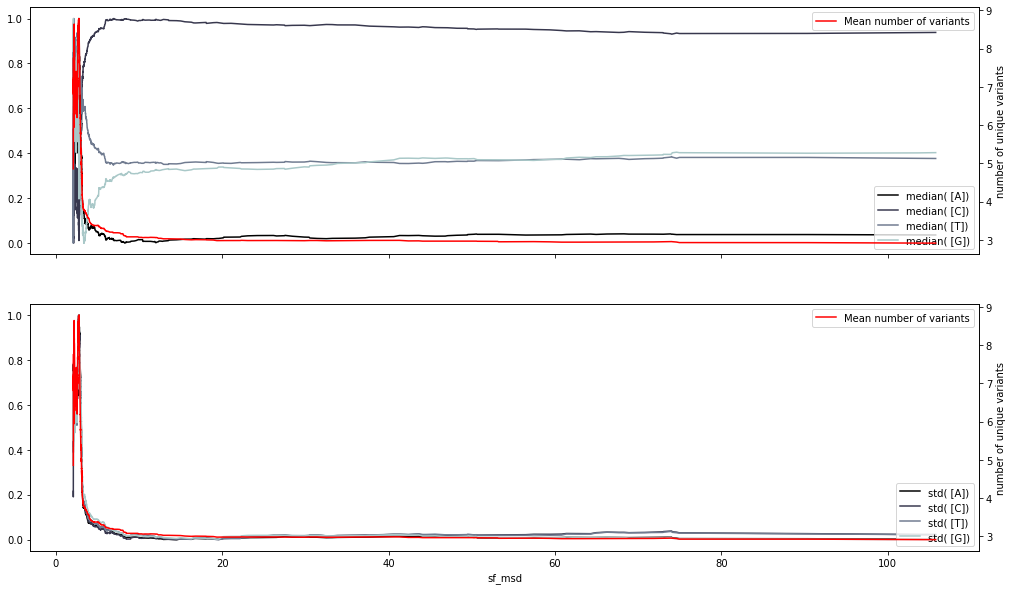

In [10]:
data_sf = data.groupby('sf_msd')
MakeDoublePanel(data_sf, [np.median,np.std],rolling=1400)

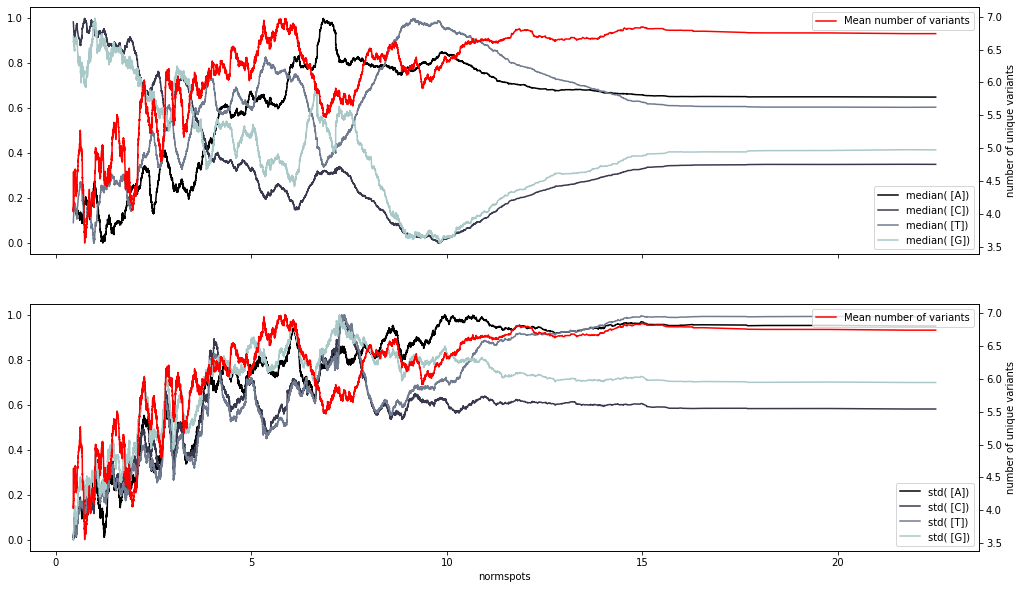

In [11]:
data_sp = data.groupby('normspots')
MakeDoublePanel(data_sp, [np.median,np.std],rolling=1400)

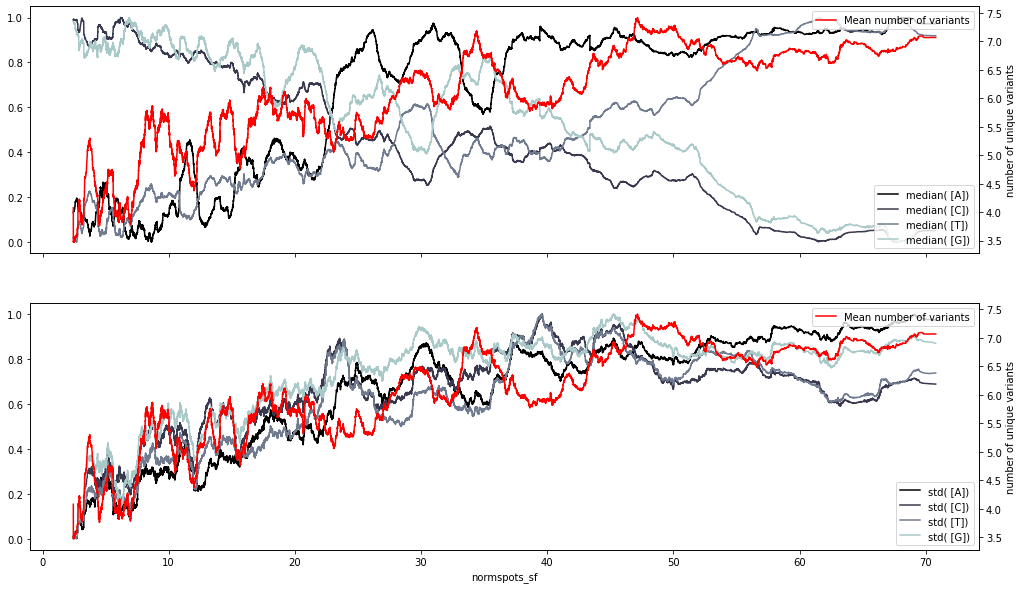

In [12]:
data_nsp = data.groupby('normspots_sf')
MakeDoublePanel(data_nsp, [np.median,np.std],rolling=1400)

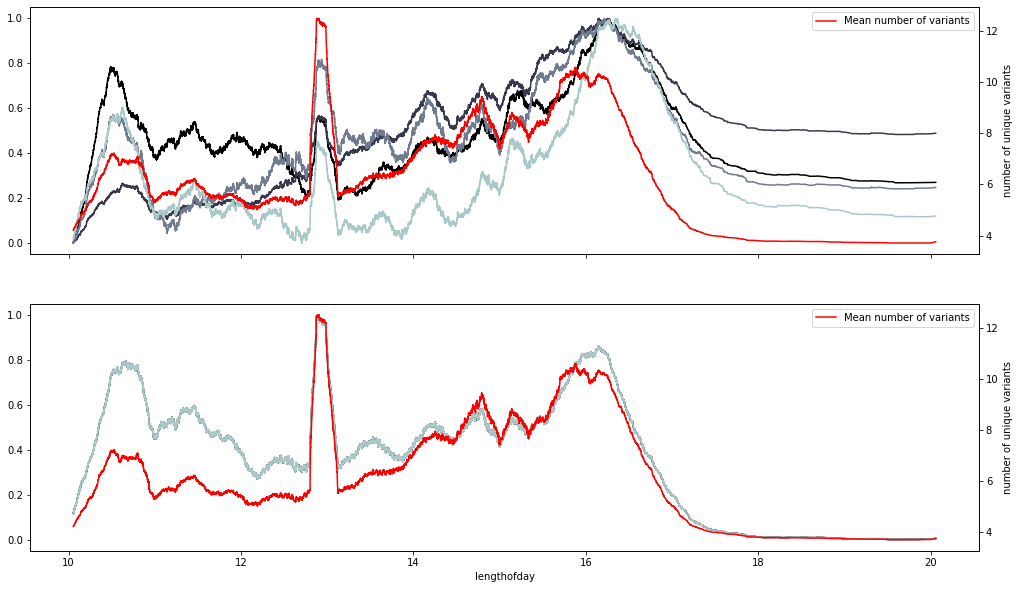

In [13]:
MakeDoublePanel(data_ld, [np.std,entropy],rolling=1400,headers=Blocks[0],label=False)

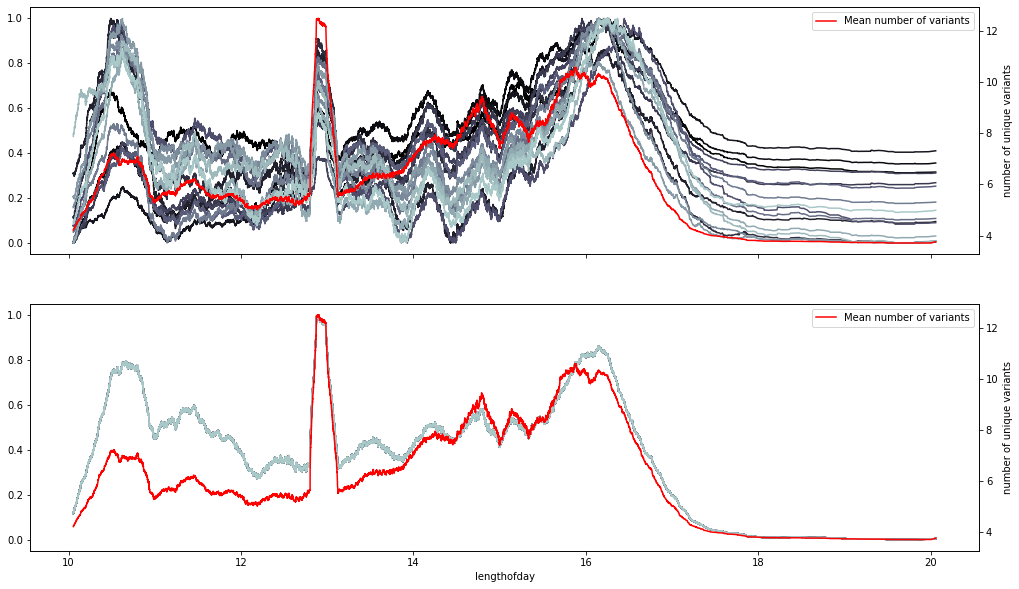

In [14]:
MakeDoublePanel(data_ld, [np.std,entropy],rolling=1400,headers=Blocks[1],label=False)

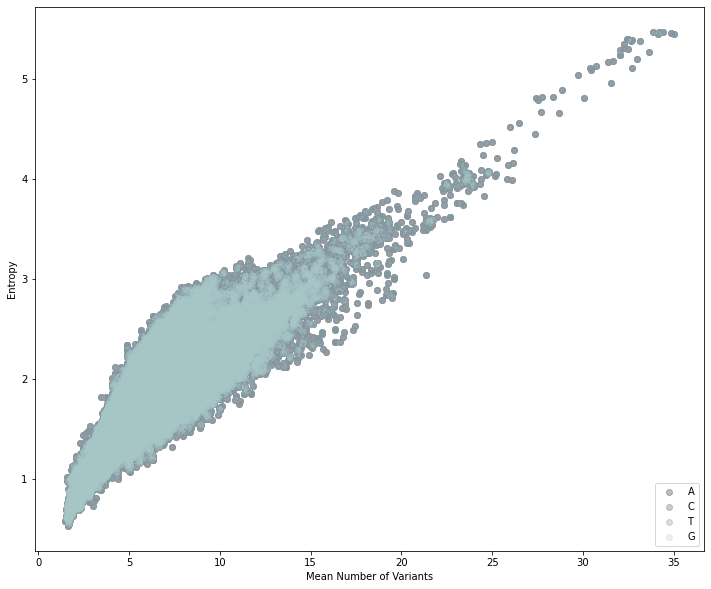

In [15]:
plt.figure(figsize=(12,10))
ax = plt.gca()
MakeScatterPlot(data_ld,ax)

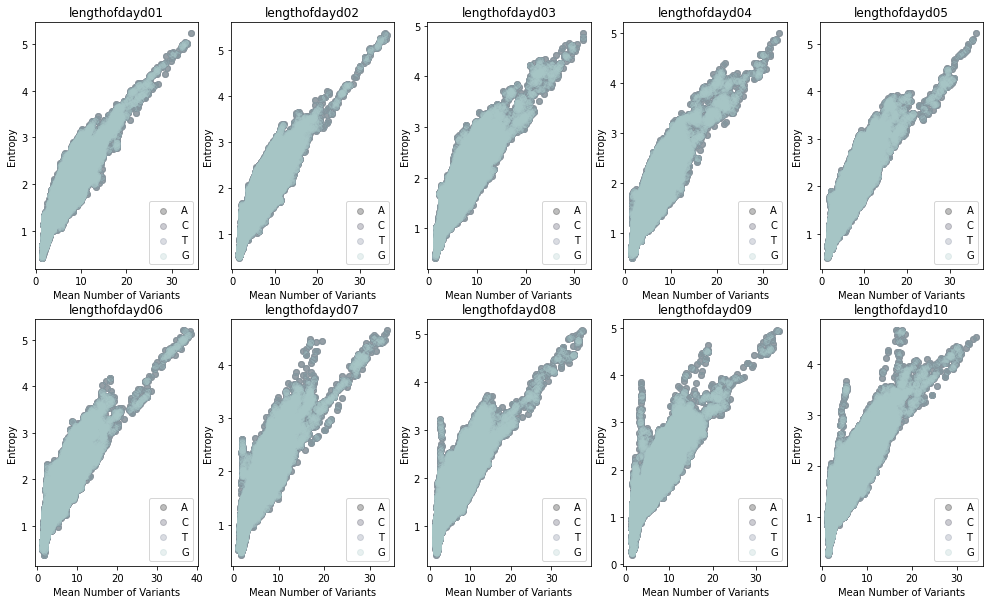

In [16]:
MakeScatterPanel(data)

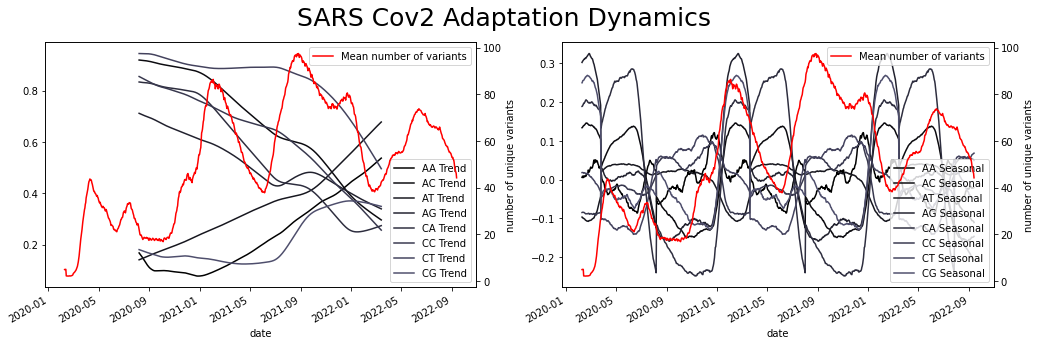

In [17]:
MakeDoubleDecompositionPanel(data_date,columns=Blocks[1],periods=[2*180,2*180,2*180,2*180,2*180,2*180,2*180,2*180])

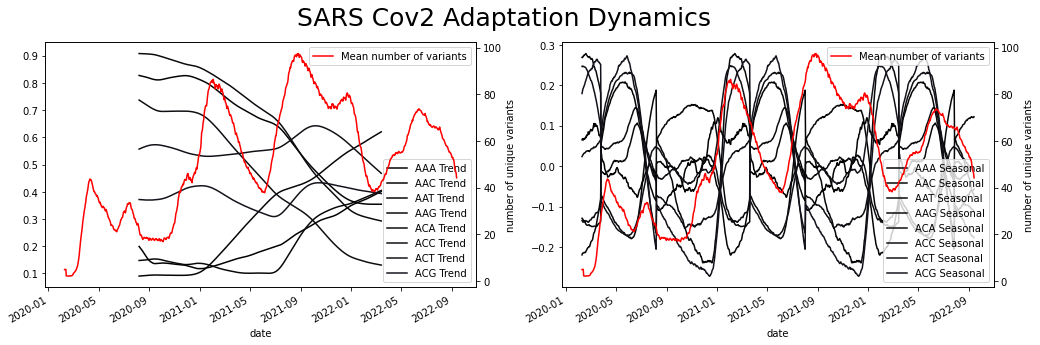

In [18]:
MakeDoubleDecompositionPanel(data_date,columns=Blocks[2],periods=[2*180,2*180,2*180,2*180,2*180,2*180,2*180,2*180])

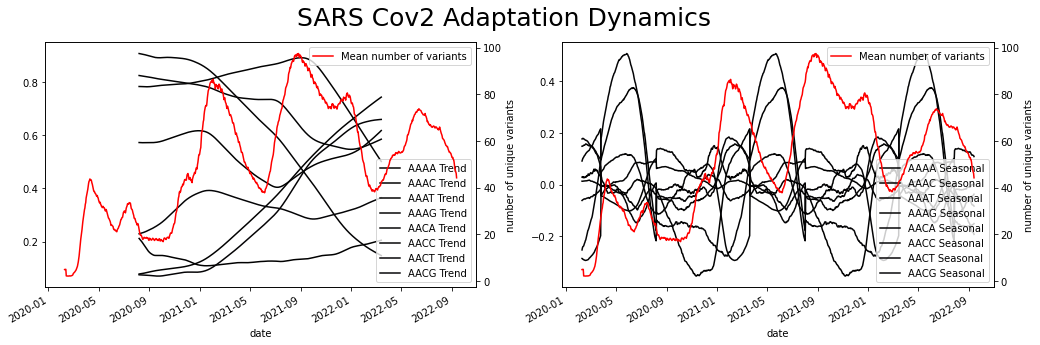

In [19]:
MakeDoubleDecompositionPanel(data_date,columns=Blocks[3],periods=[2*180,2*180,2*180,2*180,2*180,2*180,2*180,2*180])